# Phenotypes:
1. Hearing aids (f.3393)
2. Hearing difficulty/problems (f.2247)
3. Hearing difficulty/background noise (f.2257)

## Aim

Create a dataset of filtered individuals using the inclusion and exclusion criteria for diverse hearing related phenotyes to perform association analyses using the LMM.ipynb. 

## Location of files

In the shared folder is the original UKBB data
```
/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020
```

In my personal folder the filtered dataset

```
/home/dc2325/project/HI_UKBB
```

In the phenotypes folder important phenotypic files 

```
/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/hearing_impairment
```

## Important phenotypic files

1. `200804_UKBB_HI_genotypeqc.csv` File containing all individuals that passed QC and hearing impairment variables
2. `200804_UKBB_HI_genotypeqc_excr.csv` File with applied exclusion criteria as indicated [here](https://docs.google.com/document/d/1cpxTzElpsEkwmBDjnMBHg2wW7CL1AcG_b0_0wE_k5rQ/edit). **Note**: this file excludes individuals with otosclerosis, Meniere's and other diseases, if you need to filter those particular phenotypes use file 1 instead.
3. `200811_UKBB_Tinnitus_plan1_2_3_f4803` File with filtered phenotypes for tinnitus plan 1,2 and 3 and imputed noise variables
4. `200814_UKBB_HI_genotypeqc_excr_impvars` Database with qc'ed individuals, exclusion criteria, noise imputed vars and tinnitus phenotypes

## Analysis plan

The phenotypes to be analyzed are the following:

1. Hearing aid user (f.3393)
"Do you use a hearing aid most of the time?"

2. Hearing difficulty/problems (f.2247)
"Do you have any difficulty with your hearing?"

3. Hearing difficulty/background noise (f.2257)
"Do you find it difficult to follow a conversation if there is background noise (such as TV, radio, children playing)?"

**Sex corresponds to f.22001 (genetic sex):**

- Male = 0
- Female = 1

**Noisy workplace and loud music exposure frequency: same as for Tinnitus**
                
1. Remove inconsistent individuals 
    - said 1,2 or 3 and in following visits said 0
    - said a higher exposure (e.g 3) and then a lower one (e.g 1 or 2) in following visits
2. Retain consistent individuals and use highest reported exposure

**The SRT trait needs to be inverse normalized**

**Covariates to be included in the analysis include:**

1. Age at time of test (calculated from f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
2. Sex f.22001
3. Volume left ear f.4270 and right ear f.4277 (The volume set by the participant for the measurement which you are using in the analysis ir our case the last time they took the test). For the analysis we use the average of the right and left ear since there is overlap in the volume distribution
4. Noisy workplace f.4825
5. Loud music exposure f.4836


## Load imputed data

In [164]:
#Load libraries
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)
library(rapportools)
library(ggplot2)
#Get working directory
getwd()

[1] "/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/hearing_impairment"

In [2]:
#Set working directory
setwd('~/project/HI_UKBB/ukb42495_updatedJune2020')

In [3]:
# Clean workspace
rm(list=ls())

### Using only white british

In [4]:
df.final.imp = read.csv('200814_UKBB_HI_genotypeqc_excr_impvars.csv')

### Using all whites

In [4]:
df.final.imp = read.csv('120120_UKBB_HI_expandedwhite_genotypeqc_excr.csv')

## Load exome data

In [165]:
setwd('/gpfs/gibbs/pi/dewan/data/UKBiobank/phenotype_files/hearing_impairment')
df.final.imp = read.csv(file = '010421_UKBB_HI_exomes_keep.csv', header=TRUE)

In [166]:
head(df.final.imp)

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.131229.0.0,f.131230.0.0,f.131231.0.0,f.131232.0.0,f.131233.0.0,f.131250.0.0,f.131251.0.0,f.131252.0.0,f.131253.0.0,exclude
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE


## Data summary and recode

In [167]:
dim(df.final.imp) #354347 only brits 1082 vars

[1] 194097   2262

In [168]:
compare_sex <- df.final.imp %>% 
      mutate(sex_final = case_when(
       f.31.0.0 == f.22001.0.0 & f.22001.0.0 == "Female" ~ "0",
       f.31.0.0 == f.22001.0.0 & f.22001.0.0 == "Male" ~ "1",
       TRUE ~ '3')) %>%
    select(IID, f.31.0.0, f.22001.0.0, sex_final) %>%
    filter(sex_final==3)
head(compare_sex, 10)
dim(compare_sex) #Number of individuals inconsistent for self-reported and genetic sex

,IID,f.31.0.0,f.22001.0.0,sex_final
,<int>,<fct>,<fct>,<chr>
1,1045692,Female,NA,3
2,1048098,Male,NA,3
3,1068847,Male,Female,3
4,1096848,Male,NA,3
5,1101132,Male,Female,3
6,1121872,Female,NA,3
7,1161768,Male,Female,3
8,1184630,Female,NA,3
9,1236324,Male,Female,3


[1] 231   4

## Remove sex inconsistent individuals

In [170]:
remove_sex <- compare_sex %>% 
    select(IID)
head(remove_sex)
dim(remove_sex)

,IID
,<int>
1,1045692
2,1048098
3,1068847
4,1096848
5,1101132
6,1121872


[1] 231   1

In [182]:
df.final.imp <-  df.final.imp[!df.final.imp$IID %in% remove_sex$IID,]
dim(df.final.imp)

[1] 193866   2262

In [183]:
df.final.imp$sex <- revalue(df.final.imp$f.22001.0.0, c("Male" = '0', 'Female'='1' ))
table(df.final.imp$sex)
dim(df.final.imp)


     1      0 
107116  86750 

[1] 193866   2263

In [185]:
length(which(is.na(df.final.imp$sex)))

[1] 0

# f.3393 Hearing aid: filter out inconsistent cases

In [186]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.3393.0.0","f.3393.1.0","f.3393.2.0","f.3393.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: Prefer not to answer



f.3393.0.0_recode summary:
     0      1 
121552   5111 

f.3393.1.0_recode summary:
   0    1 
9208  486 

f.3393.2.0_recode summary:
    0     1 
23028  1775 

f.3393.3.0_recode summary:
  0   1 
883  67 



In [187]:
dim(df.final.imp)

[1] 193866   2267

## f. 3393 Get patterns for possible answers

In [188]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "001"  "0010" "0011" "01"  
[11] "010"  "011"  "0111" "1"    "10"   "100"  "101"  "11"   "110"  "1100"
[21] "111"  "1111"

In [189]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001    001   0010   0011     01    010 
 56472 111718  15942   3030    106      2    149      2      1   1000     19 
   011   0111      1     10    100    101     11    110   1100    111   1111 
   130      3   4651     40      6     16    471      2      1    101      4 

## f.3393 Get all the consistent cases

In [190]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(all_no,all_yes),"visit"])


     0     00    000   0000      1     11    111   1111 
111718  15942   3030    106   4651    471    101      4 

In [191]:
consistent_1<-c(all_no,all_yes)
yes_no<-all_pattern[which(grepl("0",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010  011 0111   10  100  101  110 1100 
   2  149    2    1 1000   19  130    3   40    6   16    2    1 

In [192]:
might_inconsistent<-c(yes_no)

## f.3393 Remove inconsistent cases

In [193]:
# get all the inconsistent cases:
exceptions<-c("0001","001","0011","01","011","0111")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 56472 NAs, removed

In [198]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 86 inconsistent cases, removed

In [199]:
# removed those NAs and inconsistent cases: 
IID_hearing_aid<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  select(IID)

dim(IID_hearing_aid)

[1] 137308      1

In [200]:
IID_hearing_aid<-IID_hearing_aid[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_aid)," individuals left")

After removing all the NAs and inconsistent cases, there are 137308  individuals left

In [201]:
# get the dataset after cleansing: 
df.hearing.aid<-df.final.imp %>%
  filter(IID%in%IID_hearing_aid)

dim(df.hearing.aid)

[1] 137308   2267

## f.3393 Step 1: classify cases and controls

In [202]:
hearing_aid <- df.hearing.aid %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode)
head(hearing_aid)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA


## Hearing aid f.3393

In [203]:
data_sub <- select(hearing_aid,starts_with("f.3393"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_aid$cases<-apply(data_sub, 1, f)
head(hearing_aid,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA,FALSE
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
7,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE
8,1000272,1000272,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE
9,1000304,1000304,Female,56,NA,NA,NA,0,NA,NA,NA,FALSE


In [204]:
hearing_aid_cases <- hearing_aid %>% 
  filter(cases == TRUE)
head(hearing_aid_cases)
cat(dim(hearing_aid_cases)[1], "individuals are cases for f.3393")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1001384,1001384,Female,61,NA,NA,NA,1,NA,NA,NA,TRUE
2,1002548,1002548,Male,62,NA,NA,NA,1,NA,NA,NA,TRUE
3,1002888,1002888,Male,68,NA,NA,NA,1,NA,NA,NA,TRUE
4,1002944,1002944,Male,65,NA,NA,NA,1,NA,NA,NA,TRUE
5,1003258,1003258,Male,69,74,NA,NA,0,1,NA,NA,TRUE
6,1004843,1004843,Male,64,NA,NA,NA,1,NA,NA,NA,TRUE


6512 individuals are cases for f.3393

In [205]:
hearing_aid_controls <- hearing_aid %>% 
  filter(cases == FALSE)
head(hearing_aid_controls)
cat(dim(hearing_aid_controls)[1], "individuals are controls for f.3393")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA,FALSE
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE


130796 individuals are controls for f.3393

In [208]:
dim(hearing_aid)[1]-6512 -130796

[1] 0

## f.3393 Recode cases=1 and controls=0

In [209]:
hearing_aid$hearing_aid_cat <- as.integer(as.logical(hearing_aid$cases))
head(hearing_aid, 10)
# Get the number of NAs
#length(which(is.na(hearing_all$hearing_aid_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases,hearing_aid_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE,0
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE,0
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA,FALSE,0
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE,0
7,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE,0
8,1000272,1000272,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE,0
9,1000304,1000304,Female,56,NA,NA,NA,0,NA,NA,NA,FALSE,0


In [210]:
dim(hearing_aid)

[1] 137308     13

## Step 2: get the ages for hearing aids (f.3393)

In [211]:
# Get the subset data of cases
aid_age_cases = hearing_aid %>% 
  filter(hearing_aid_cat=="1")  %>%
  select(IID, f.3393.0.0_recode, f.3393.1.0_recode, f.3393.2.0_recode, f.3393.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(aid_age_cases,12)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1001384,1,NA,NA,NA,61,NA,NA,NA
2,1002548,1,NA,NA,NA,62,NA,NA,NA
3,1002888,1,NA,NA,NA,68,NA,NA,NA
4,1002944,1,NA,NA,NA,65,NA,NA,NA
5,1003258,0,1,NA,NA,69,74,NA,NA
6,1004843,1,NA,NA,NA,64,NA,NA,NA
7,1006454,1,NA,NA,NA,64,NA,NA,NA
8,1006513,0,NA,1,NA,54,NA,59,NA
9,1007725,1,NA,NA,NA,69,NA,NA,NA


In [212]:
# Get the # of column where first replied Yes:
aid_age_cases$visit_idx = apply(aid_age_cases, 1, function(x) unlist(which(x == '1')))
head(aid_age_cases)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1001384,1,NA,NA,NA,61,NA,NA,NA,2
2,1002548,1,NA,NA,NA,62,NA,NA,NA,2
3,1002888,1,NA,NA,NA,68,NA,NA,NA,2
4,1002944,1,NA,NA,NA,65,NA,NA,NA,2
5,1003258,0,1,NA,NA,69,74,NA,NA,3
6,1004843,1,NA,NA,NA,64,NA,NA,NA,2


In [213]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(aid_age_cases) == 'f.21003.0.0') - which(colnames(aid_age_cases) == 'f.3393.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(aid_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
aid_age_cases$age_final_aid = apply(aid_age_cases, 1, f)

# Show first 6 rows
head(aid_age_cases)
summary(aid_age_cases$age_final_aid)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1001384,1,NA,NA,NA,61,NA,NA,NA,2,61
2,1002548,1,NA,NA,NA,62,NA,NA,NA,2,62
3,1002888,1,NA,NA,NA,68,NA,NA,NA,2,68
4,1002944,1,NA,NA,NA,65,NA,NA,NA,2,65
5,1003258,0,1,NA,NA,69,74,NA,NA,3,74
6,1004843,1,NA,NA,NA,64,NA,NA,NA,2,64


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   60.00   65.00   63.68   68.00   82.00 

In [214]:
### Extract age for Control (3393)
aid_age_control <- hearing_aid %>% 
  filter(hearing_aid_cat == "0") %>%
  select(IID, f.3393.0.0_recode, f.3393.1.0_recode, f.3393.2.0_recode, f.3393.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(aid_age_control)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,0,NA,NA,NA,47,NA,NA,NA
2,1000035,0,NA,NA,NA,63,NA,NA,NA
3,1000078,NA,0,0,NA,52,57,60,NA
4,1000081,0,NA,NA,NA,67,NA,NA,NA
5,1000198,0,NA,NA,NA,41,NA,NA,NA
6,1000236,0,NA,0,NA,61,NA,70,NA


In [215]:
# Get the # of column where last replied No:
aid_age_control$visit_idx = apply(aid_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(aid_age_control) == 'f.21003.0.0') - which(colnames(aid_age_control) == 'f.3393.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(aid_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
aid_age_control$age_final_aid = apply(aid_age_control, 1, f)

# Show first 6 rows
head(aid_age_control)
summary(aid_age_control$age_final_aid)

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,0,NA,NA,NA,47,NA,NA,NA,2,47
2,1000035,0,NA,NA,NA,63,NA,NA,NA,2,63
3,1000078,NA,0,0,NA,52,57,60,NA,"3, 4",60
4,1000081,0,NA,NA,NA,67,NA,NA,NA,2,67
5,1000198,0,NA,NA,NA,41,NA,NA,NA,2,41
6,1000236,0,NA,0,NA,61,NA,70,NA,"2, 4",70


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   52.00   59.00   58.09   65.00   82.00 

In [216]:
# Merge age_cases and age_controls
hearing_aid_age <- rbind(aid_age_cases, aid_age_control) 
dim(hearing_aid_age)
head(hearing_aid_age)

[1] 137308     11

,IID,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_aid
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1001384,1,NA,NA,NA,61,NA,NA,NA,2,61
2,1002548,1,NA,NA,NA,62,NA,NA,NA,2,62
3,1002888,1,NA,NA,NA,68,NA,NA,NA,2,68
4,1002944,1,NA,NA,NA,65,NA,NA,NA,2,65
5,1003258,0,1,NA,NA,69,74,NA,NA,3,74
6,1004843,1,NA,NA,NA,64,NA,NA,NA,2,64


In [217]:
hearing_cat_age = merge(x = hearing_aid ,y = hearing_aid_age [,c("IID","age_final_aid")],by="IID", all.x=TRUE)
head(hearing_cat_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,cases,hearing_aid_cat,age_final_aid
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,0,NA,NA,NA,FALSE,0,47
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0,63
3,1000078,1000078,Female,52,57,60,NA,NA,0,0,NA,FALSE,0,60
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0,67
5,1000198,1000198,Female,41,NA,NA,NA,0,NA,NA,NA,FALSE,0,41
6,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE,0,70


In [218]:
#Merge with complete database keep the all the rows from original db
df_3393 = merge(x = df.final.imp, y = hearing_cat_age [,c("IID","hearing_aid_cat","age_final_aid")],by="IID", all.x=TRUE)
dim(df_3393)
head(df_3393)

[1] 193866   2269

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.131252.0.0,f.131253.0.0,exclude,sex,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,hearing_aid_cat,age_final_aid
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<fct>,<lgl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,NA,FALSE,1,0,NA,NA,NA,0,47
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,NA,FALSE,0,0,NA,NA,NA,0,63
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,NA,FALSE,1,NA,0,0,NA,0,60
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,NA,FALSE,0,0,NA,NA,NA,0,67
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,NA,NA,FALSE,1,0,NA,NA,NA,0,41
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,NA,NA,FALSE,0,NA,NA,NA,NA,NA,NA


## Export file for hearing aid analysis f.3393

In [219]:
f.3393_pheno <- df_3393 %>%
    filter(!(is.na(hearing_aid_cat))) %>%
    select(FID, IID, age_final_aid, sex, hearing_aid_cat) 
#%>%mutate(hearing_aid_cat=recode_factor(hearing_aid_cat, `1`="case",`0`="control"), sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f.3393_pheno)
dim(f.3393_pheno)

,FID,IID,age_final_aid,sex,hearing_aid_cat
,<int>,<int>,<int>,<fct>,<int>
1,1000019,1000019,47,1,0
2,1000035,1000035,63,0,0
3,1000078,1000078,60,1,0
4,1000081,1000081,67,0,0
5,1000198,1000198,41,1,0
6,1000236,1000236,70,0,0


[1] 137308      5

## Histogram for age of cases and controls

In [220]:
mu <- ddply(f.3393_pheno, "hearing_aid_cat", summarise, grp.mean=mean(age_final_aid))
head(mu)

,hearing_aid_cat,grp.mean
,<int>,<dbl>
1,0,58.09252
2,1,63.67521


In [ ]:
ggplot(f.3393_pheno, aes(x=age_final_aid, fill=hearing_aid_cat, color=hearing_aid_cat)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu, aes(xintercept=grp.mean, color=hearing_aid_cat),
             linetype="dashed") +
  theme_classic()

In [222]:
length(which((f.3393_pheno$hearing_aid_cat=="0" & f.3393_pheno$age_final_aid <50)))

[1] 24381

In [223]:
length(which((f.3393_pheno$hearing_aid_cat=="1" & f.3393_pheno$age_final_aid <50)))

[1] 298

In [224]:
mu1 <- ddply(f.3393_pheno, "sex", summarise, grp.mean=mean(age_final_aid))
head(mu1)

,sex,grp.mean
,<fct>,<dbl>
1,1,57.98607
2,0,58.77584


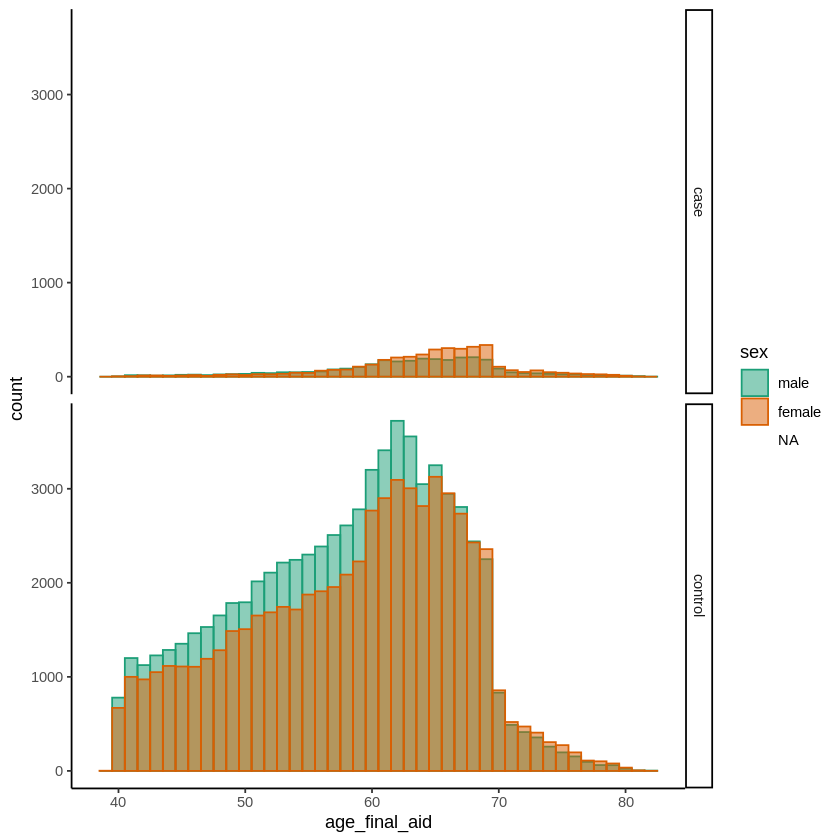

In [43]:
ggplot(f.3393_pheno, aes(x=age_final_aid, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_aid_cat ~ .)

## Find out controls positive for f.2247 & f.2257

In [225]:
control_check_3393 <- df_3393 %>%
    filter(hearing_aid_cat==0) %>%
    select(FID, IID, age_final_aid, sex, hearing_aid_cat, starts_with("f.2247"), starts_with("f.2257")) %>%
    mutate(remove_2247 = apply(select(.,starts_with("f.2247")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_2257 = apply(select(.,starts_with("f.2257")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_3393)
dim(control_check_3393)

,FID,IID,age_final_aid,sex,hearing_aid_cat,f.2247.0.0,f.2247.1.0,f.2247.2.0,f.2247.3.0,f.2257.0.0,f.2257.1.0,f.2257.2.0,f.2257.3.0,remove_2247,remove_2257
,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000019,1000019,47,1,0,Yes,NA,NA,NA,Yes,NA,NA,NA,TRUE,TRUE
2,1000035,1000035,63,0,0,No,NA,NA,NA,Yes,NA,NA,NA,FALSE,TRUE
3,1000078,1000078,60,1,0,No,No,No,NA,No,No,No,NA,FALSE,FALSE
4,1000081,1000081,67,0,0,No,NA,NA,NA,No,NA,NA,NA,FALSE,FALSE
5,1000198,1000198,41,1,0,Yes,NA,NA,NA,Yes,NA,NA,NA,TRUE,TRUE
6,1000236,1000236,70,0,0,No,NA,No,NA,No,NA,No,NA,FALSE,FALSE


[1] 130796     15

In [226]:
length(which(control_check_3393$remove_2247==TRUE)) #controls that replied yes to f.2247
length(which(control_check_3393$remove_2257==TRUE)) #controls that replied yes to f.2257
length(which(control_check_3393$remove_2247==TRUE & control_check_3393$remove_2257==TRUE)) # controls that replied yes to both
length(which(control_check_3393$remove_2247==TRUE | control_check_3393$remove_2257==TRUE)) # controls that replied yes to either

[1] 43619

[1] 67781

[1] 35879

[1] 75521

### Export files only white-British

In [44]:
write.table(f.3393_pheno, '200828_UKBB_Hearing_aid_f3393', quote = FALSE, row.names = FALSE)

### Export files expanded white

In [44]:
write.table(f.3393_pheno, '120120_UKBB_Hearing_aid_f3393_expandedwhite', quote = FALSE, row.names = FALSE)

### Export files exome data

In [228]:
write.table(f.3393_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_aid_f3393_exomes', quote = FALSE, row.names = FALSE)

## Hearing difficulty/problems (2247)
### step1: classify cases and controls

In [229]:
table(df.final.imp$f.2247.0.0)
dim(df.final.imp)


         Do not know I am completely deaf                   No 
                8239                   35               139182 
Prefer not to answer                  Yes 
                 172                45961 

[1] 193866   2267

In [230]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA,
                                             "Do not know"=9,
                                             "I am completely deaf"=NA))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.2247.0.0","f.2247.1.0","f.2247.2.0","f.2247.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer, I am completely deaf

The following `from` values were not present in `x`: Prefer not to answer, I am completely deaf



f.2247.0.0_recode summary:
     9      0      1 
  8239 139182  45961 

f.2247.1.0_recode summary:
   9    0    1 
 529 6221 2944 

f.2247.2.0_recode summary:
    9     0     1 
 1327 15443  8040 

f.2247.3.0_recode summary:
  9   0   1 
 47 575 328 



## f.2247 Get possible answers

In [231]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "0009" "001"  "0010" "0011"
[11] "0019" "009"  "0090" "0091" "0099" "01"   "010"  "0100" "0101" "011" 
[21] "0111" "019"  "09"   "090"  "0900" "0901" "091"  "0910" "0911" "099" 
[31] "0991" "1"    "10"   "100"  "1000" "101"  "109"  "1090" "1099" "11"  
[41] "110"  "1101" "111"  "1111" "1119" "119"  "1190" "1191" "19"   "190" 
[51] "1900" "191"  "199"  "9"    "90"   "900"  "9000" "901"  "909"  "91"  
[61] "910"  "911"  "9110" "9111" "919"  "99"   "990"  "991"  "999"

In [232]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001   0009    001   0010   0011   0019 
   397 117980  13255   3031     79     10      6    345      3      7      1 
   009   0090   0091   0099     01    010   0100   0101    011   0111    019 
   114      3      1      1   2774    134      3      1    389      7     30 
    09    090   0900   0901    091   0910   0911    099   0991      1     10 
   853     96      1      2     50      1      2     50      1  39116    891 
   100   1000    101    109   1090   1099     11    110   1101    111   1111 
   119      1     78      8      1      1   4375     82      1    965     26 
  1119    119   1190   1191     19    190   1900    191    199      9     90 
     1     32      1      1    245     17      1     16     14   7128    375 
   900   9000    901    909     91    910    911   9110   9111    919     99 
    55      3     10     21    344      8     62      1      1      2    179 
   990    991    999 
    24     16     18 

## f.2247 Get all the consistent cases

In [233]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


     0     00    000   0000      1     11    111   1111      9     99    999 
117980  13255   3031     79  39116   4375    965     26   7128    179     18 

In [234]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


0009  009 0090 0099   09  090 0900  099   90  900 9000  909  990 
   6  114    3    1  853   96    1   50  375   55    3   21   24 

In [235]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


1119  119 1191   19  191  199   91  911 9111  919  991 
   1   32    1  245   16   14  344   62    1    2   16 

In [236]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100 0101  011 0111   10  100 1000  101  110 1101 
  10  345    3    7 2774  134    3    1  389    7  891  119    1   78   82    1 

In [237]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


0019 0091  019 0901  091 0910 0911 0991  109 1090 1099 1190  190 1900  901  910 
   1    1   30    2   50    1    2    1    8    1    1    1   17    1   10    8 
9110 
   1 

In [238]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

## f.2247 Remove inconsistent cases

In [239]:
# get all the inconsistent cases:
exceptions<-c("91","911","9111","991","0001","001","0011","01","011","0111", "0091", "091","0911","0991","9001","901","9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 397 NAs, removed

In [240]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 3298 inconsistent cases, removed

In [241]:
# removed those NAs, consistent for do not know - 9 and inconsistent cases: 
IID_hearing_diff<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  filter((!visit%in%all_do_not_know)) %>%
  select(IID)

dim(IID_hearing_diff)

[1] 182846      1

In [242]:
IID_hearing_diff<-IID_hearing_diff[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_diff),"cases left")

After removing all the NAs and inconsistent cases, there are 182846 cases left

In [243]:
# get the dataset after cleansing: 
df.hearing.diff<-df.final.imp %>%
  filter(IID%in%IID_hearing_diff)

dim(df.hearing.diff)

[1] 182846   2271

## f.2247 Step 1 classify cases and controls

In [244]:
hearing_diff <- df.hearing.diff %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode)
head(hearing_diff)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA
6,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA


In [245]:
data_sub <- select(hearing_diff,starts_with("f.2247"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_diff$cases<-apply(data_sub, 1, f)
head(hearing_diff,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE
7,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
8,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE
9,1000272,1000272,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE


In [246]:
hearing_diff_cases <- hearing_diff %>% 
  filter(cases == TRUE)
head(hearing_diff_cases)
cat(dim(hearing_diff_cases)[1], "individuals are cases for f.2247")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000396,1000396,Male,48,NA,NA,NA,1,NA,NA,NA,TRUE
4,1000494,1000494,Male,61,NA,NA,NA,1,NA,NA,NA,TRUE
5,1001076,1001076,Male,69,NA,NA,NA,1,NA,NA,NA,TRUE
6,1001123,1001123,Female,62,NA,NA,NA,1,NA,NA,NA,TRUE


48501 individuals are cases for f.2247

In [247]:
hearing_diff_controls <- hearing_diff %>% 
  filter(cases == FALSE)
head(hearing_diff_controls)
cat(dim(hearing_diff_controls)[1], "individuals are controls for f.2247")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE
2,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
3,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
6,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE


134345 individuals are controls for f.2247

In [64]:
dim(hearing_diff)[1]-246072 - 91057

[1] 39974

## f.2247 Recode cases=1 and controls=0

In [248]:
hearing_diff$hearing_diff_cat <- as.integer(as.logical(hearing_diff$cases))
head(hearing_diff, 10)
# Get the number of NAs
length(which(is.na(hearing_diff$hearing_dif_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases,hearing_diff_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE,1
6,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE,0
7,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE,0
8,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE,0
9,1000272,1000272,Male,43,NA,NA,NA,0,NA,NA,NA,FALSE,0


[1] 0

## f.2247 Step 2: get the ages for hearing difficulty

In [249]:
# Get the subset data of cases
diff_age_cases = hearing_diff %>% 
  filter(hearing_diff_cat=="1")  %>%
  select(IID, f.2247.0.0_recode, f.2247.1.0_recode, f.2247.2.0_recode, f.2247.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(diff_age_cases,12)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA
2,1000198,1,NA,NA,NA,41,NA,NA,NA
3,1000396,1,NA,NA,NA,48,NA,NA,NA
4,1000494,1,NA,NA,NA,61,NA,NA,NA
5,1001076,1,NA,NA,NA,69,NA,NA,NA
6,1001123,1,NA,NA,NA,62,NA,NA,NA
7,1001316,0,NA,1,NA,45,NA,51,NA
8,1001373,1,NA,NA,NA,67,NA,NA,NA
9,1001384,1,NA,NA,NA,61,NA,NA,NA


In [250]:
# Get the # of column where first replied Yes:
diff_age_cases$visit_idx = apply(diff_age_cases, 1, function(x) unlist(which(x == '1')))
head(diff_age_cases)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2
2,1000198,1,NA,NA,NA,41,NA,NA,NA,2
3,1000396,1,NA,NA,NA,48,NA,NA,NA,2
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2
5,1001076,1,NA,NA,NA,69,NA,NA,NA,2
6,1001123,1,NA,NA,NA,62,NA,NA,NA,2


In [251]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.22247.0.0_recode)
offset = which(colnames(diff_age_cases) == 'f.21003.0.0') - which(colnames(diff_age_cases) == 'f.2247.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(diff_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
diff_age_cases$age_final_diff = apply(diff_age_cases, 1, f)

# Show first 6 rows
head(diff_age_cases)
summary(diff_age_cases$age_final_diff)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41
3,1000396,1,NA,NA,NA,48,NA,NA,NA,2,48
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61
5,1001076,1,NA,NA,NA,69,NA,NA,NA,2,69
6,1001123,1,NA,NA,NA,62,NA,NA,NA,2,62


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  39.00   54.00   61.00   59.25   65.00   81.00 

In [252]:
### Extract age for Control (2247)
diff_age_control <- hearing_diff %>% 
  filter(hearing_diff_cat == "0") %>%
  select(IID, f.2247.0.0_recode, f.2247.1.0_recode, f.2247.2.0_recode, f.2247.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(diff_age_control)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000035,0,NA,NA,NA,63,NA,NA,NA
2,1000078,0,0,0,NA,52,57,60,NA
3,1000081,0,NA,NA,NA,67,NA,NA,NA
4,1000224,0,NA,NA,NA,58,NA,NA,NA
5,1000236,0,NA,0,NA,61,NA,70,NA
6,1000255,0,NA,0,NA,51,NA,61,NA


In [253]:
# Get the # of column where last replied No:
diff_age_control$visit_idx = apply(diff_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.3393.0.0_recode)
offset = which(colnames(diff_age_control) == 'f.21003.0.0') - which(colnames(diff_age_control) == 'f.2247.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(diff_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
diff_age_control$age_final_diff = apply(diff_age_control, 1, f)

# Show first 6 rows
head(diff_age_control)
summary(diff_age_control$age_final_diff)

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000035,0,NA,NA,NA,63,NA,NA,NA,2,63
2,1000078,0,0,0,NA,52,57,60,NA,"2, 3, 4",60
3,1000081,0,NA,NA,NA,67,NA,NA,NA,2,67
4,1000224,0,NA,NA,NA,58,NA,NA,NA,2,58
5,1000236,0,NA,0,NA,61,NA,70,NA,"2, 4",70
6,1000255,0,NA,0,NA,51,NA,61,NA,"2, 4",61


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38.00   50.00   58.00   56.59   63.00   82.00 

In [254]:
# Merge age_cases and age_controls
hearing_diff_age <- rbind(diff_age_cases, diff_age_control) 
dim(hearing_diff_age)
head(hearing_diff_age)

[1] 182846     11

,IID,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_diff
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41
3,1000396,1,NA,NA,NA,48,NA,NA,NA,2,48
4,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61
5,1001076,1,NA,NA,NA,69,NA,NA,NA,2,69
6,1001123,1,NA,NA,NA,62,NA,NA,NA,2,62


In [255]:
hearing_diff_age = merge(x = hearing_diff ,y = hearing_diff_age [,c("IID","age_final_diff")],by="IID", all.x=TRUE)
head(hearing_diff_age)
dim(hearing_diff_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2247.0.0_recode,f.2247.1.0_recode,f.2247.2.0_recode,f.2247.3.0_recode,cases,hearing_diff_cat,age_final_diff
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1,47
2,1000035,1000035,Male,63,NA,NA,NA,0,NA,NA,NA,FALSE,0,63
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0,60
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0,67
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE,1,41
6,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE,0,58


[1] 182846     14

## Merge dataset from f.3393 and f.2247

In [256]:
#Merge with complete database keep the all the rows from original db
df_3393_2247 = merge(x = df_3393, y = hearing_diff_age [,c("IID","hearing_diff_cat","age_final_diff")],by="IID", all.x=TRUE)
dim(df_3393_2247)
head(df_3393_2247)

[1] 193866   2271

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,exclude,sex,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<lgl>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,FALSE,1,0,NA,NA,NA,0,47,1,47
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,FALSE,0,0,NA,NA,NA,0,63,0,63
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,FALSE,1,NA,0,0,NA,0,60,0,60
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,FALSE,0,0,NA,NA,NA,0,67,0,67
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,FALSE,1,0,NA,NA,NA,0,41,1,41
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,FALSE,0,NA,NA,NA,NA,NA,NA,NA,NA


## Reclassify individuals wearing hearing aid f.3393 but saying they don't have hearing difficulty f.2247

In [257]:
#reclassify these 85 individulas as cases for 2247
df_3393_2247$hearing_diff_cat_new <- as.factor(df_3393_2247$hearing_diff_cat)
df_3393_2247$hearing_diff_cat_new <- revalue(df_3393_2247$hearing_diff_cat_new, c('0' = "control", '1' = 'case' ))
df_3393_2247$hearing_aid_cat_new <- as.factor(df_3393_2247$hearing_aid_cat)
df_3393_2247$hearing_aid_cat_new <- revalue(df_3393_2247$hearing_aid_cat_new, c('0' = "control", '1' = 'case' ))
#hearing_diff_new <- df_3393_2247 %>% 
 # mutate(hearing_diff_cat_new =ifelse(IID%in%inconsistent_aid_diff,1,hearing_diff_cat_new))
#head(hearing_diff_new)

In [75]:
246072 + 91057 # number of controls and cases

[1] 337129

In [258]:
length(which(df_3393_2247$hearing_diff_cat_new == 'control' & df_3393_2247$hearing_aid_cat_new == 'case'))

[1] 80

In [259]:
#85 individuals state they have no hearing difficulty but they wear hearing aids
inconsistent_aid_diff <- df_3393_2247 %>%
    filter(hearing_diff_cat_new == 'control' & hearing_aid_cat_new == 'case') %>%
    select(IID)
nrow(inconsistent_aid_diff)
head(inconsistent_aid_diff)

[1] 80

,IID
,<int>
1,1187252
2,1200917
3,1210033
4,1311088
5,1362299
6,1411923


In [260]:
inconsistent_aid_diff<-unlist(inconsistent_aid_diff[,1])
cat("There are",length(inconsistent_aid_diff),"individuals that state having no hearing difficulty but wear hearing aid")

There are 80 individuals that state having no hearing difficulty but wear hearing aid

In [263]:
df_3393_2247$hearing_diff_new <- df_3393_2247$hearing_diff_cat_new
df_3393_2247$hearing_diff_new[df_3393_2247$IID %in% inconsistent_aid_diff] <- "case"

In [264]:
#91057 individuals plus 85 that wear hearing aid = 91142
check_merge <- df_3393_2247 %>% 
  select(hearing_diff_cat_new, hearing_aid_cat_new, hearing_diff_new) %>%
  filter(hearing_diff_new == "case")
head(check_merge)
nrow(check_merge)

,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new
,<fct>,<fct>,<fct>
1,case,control,case
2,case,control,case
3,case,control,case
4,case,control,case
5,case,control,case
6,case,control,case


[1] 48581

## f.2247 Verify the age for the new 85 cases

In [265]:
age_inconsistent <- df_3393_2247 %>%
    select(IID, age_final_aid, age_final_diff) %>%
    filter(IID %in% inconsistent_aid_diff)
head(age_inconsistent, 100)

,IID,age_final_aid,age_final_diff
,<int>,<int>,<int>
1,1187252,51,51
2,1200917,70,70
3,1210033,60,60
4,1311088,49,49
5,1362299,45,45
6,1411923,48,48
7,1517018,62,62
8,1541460,66,66
9,1546451,57,57


In [266]:
# There are not inconsistencies in the age of the 85 new cases therefore I can use the age_final_diff variable
all(age_inconsistent$age_final_aid == age_inconsistent$age_final_diff)

[1] TRUE

## Export file for hearing difficulty f.2247

In [267]:
df_3393_2247$hearing_diff_new <- revalue(df_3393_2247$hearing_diff_new, c('control' = "0", 'case' = '1' ))

In [268]:
f.2247_pheno <- df_3393_2247 %>%
    filter(!(is.na(hearing_diff_new))) %>%
    select(FID, IID, age_final_diff, sex, hearing_diff_new)
head(f.2247_pheno)
dim(f.2247_pheno)

,FID,IID,age_final_diff,sex,hearing_diff_new
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,1,1
2,1000035,1000035,63,0,0
3,1000078,1000078,60,1,0
4,1000081,1000081,67,0,0
5,1000198,1000198,41,1,1
6,1000224,1000224,58,1,0


[1] 182846      5

## Histogram for age in f.2247

In [269]:
mu3 <- ddply(f.2247_pheno, "hearing_diff_new", summarise, grp.mean=mean(age_final_diff))
head(mu3)

,hearing_diff_new,grp.mean
,<fct>,<dbl>
1,0,56.59088
2,1,59.24532


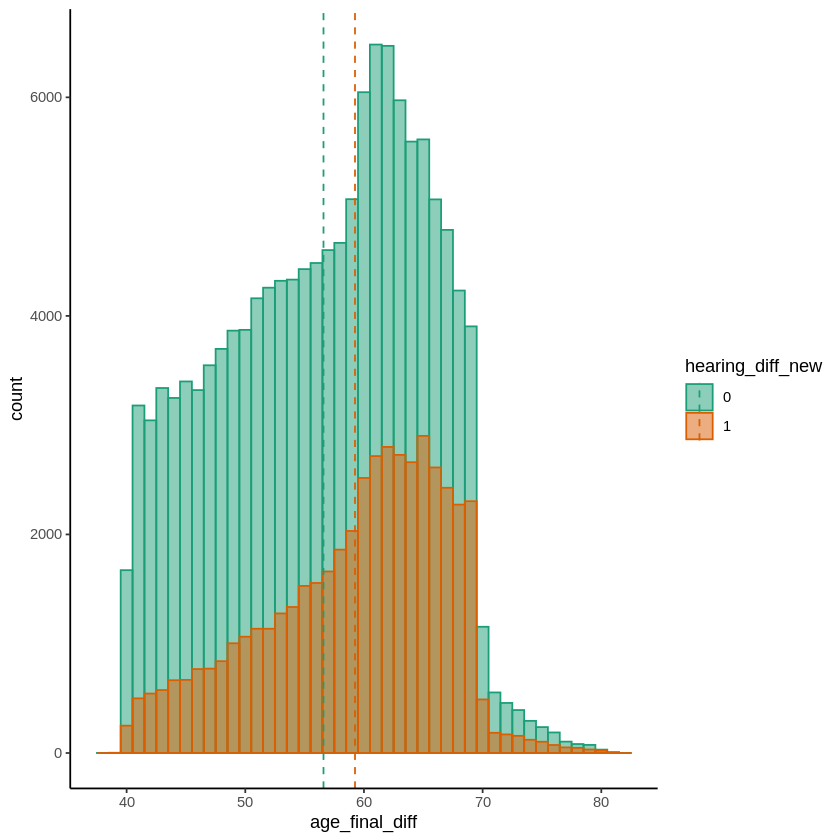

In [270]:
ggplot(f.2247_pheno, aes(x=age_final_diff, fill=hearing_diff_new, color=hearing_diff_new)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu3, aes(xintercept=grp.mean, color=hearing_diff_new),
             linetype="dashed") +
  theme_classic()

In [271]:
length(which((f.2247_pheno$hearing_diff_new=="control" & f.2247_pheno$age_final_diff <50)))
length(which((f.2247_pheno$hearing_diff_new=="case" & f.2247_pheno$age_final_diff <50)))

[1] 0

[1] 0

In [272]:
mu4 <- ddply(f.2247_pheno, "sex", summarise, grp.mean=mean(age_final_diff))
head(mu1)

,sex,grp.mean
,<fct>,<dbl>
1,1,57.98607
2,0,58.77584


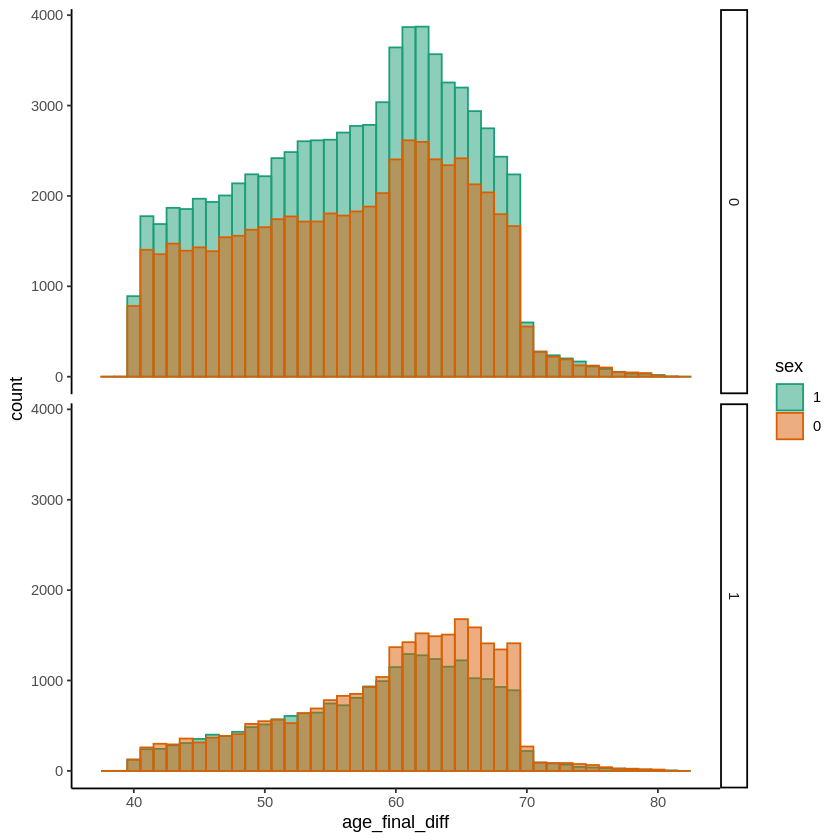

In [273]:
ggplot(f.2247_pheno, aes(x=age_final_diff, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_diff_new ~ .)

## Filter controls positive for f.3393 and/or f.2257

In [274]:
control_check_2247 <- df_3393_2247 %>%
    filter(hearing_diff_new==0) %>%
    select(FID, IID, age_final_diff, sex, hearing_diff_new, starts_with("f.2257"), starts_with("f.3393")) %>%
    mutate(remove_2257 = apply(select(.,starts_with("f.2257")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_2247)

,FID,IID,age_final_diff,sex,hearing_diff_new,f.2257.0.0,f.2257.1.0,f.2257.2.0,f.2257.3.0,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_2257,remove_3393
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000035,1000035,63,0,0,Yes,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,TRUE,FALSE
2,1000078,1000078,60,1,0,No,No,No,NA,NA,No,No,NA,NA,0,0,NA,FALSE,FALSE
3,1000081,1000081,67,0,0,No,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,FALSE,FALSE
4,1000224,1000224,58,1,0,No,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,FALSE
5,1000236,1000236,70,0,0,No,NA,No,NA,No,NA,No,NA,0,NA,0,NA,FALSE,FALSE
6,1000255,1000255,61,1,0,No,NA,No,NA,No,NA,No,NA,0,NA,0,NA,FALSE,FALSE


In [275]:
length(which(control_check_2247$remove_2257==TRUE)) #controls that replied yes to f.2257
length(which(control_check_2247$remove_3393==TRUE)) #controls that replied yes to f.3393
length(which(control_check_2247$remove_2257==TRUE & control_check_2247$remove_3393==TRUE)) # controls that replied yes to both
length(which(control_check_2247$remove_2257==TRUE | control_check_2247$remove_3393==TRUE)) # controls that replied yes to either

[1] 27215

[1] 4

[1] 1

[1] 27218

### Export file white-British

In [93]:
write.table(f.2247_pheno, '200828_UKBB_Hearing_difficulty_f2247', quote = FALSE, row.names = FALSE)

### Export file white expanded

In [93]:
write.table(f.2247_pheno, '120120_UKBB_Hearing_difficulty_f2247_expandedwhite', quote = FALSE, row.names = FALSE)

### Export file exome data

In [276]:
length(which(is.na(f.2247_pheno$hearing_diff_new)))

[1] 0

In [277]:
write.table(f.2247_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_difficulty_f2247_exomes', quote = FALSE, row.names = FALSE)

## f.2257 Hearing difficulty/background noise (2257)
### step1: classify cases and controls

In [278]:
table(df.final.imp$f.2257.0.0)
dim(df.final.imp)


         Do not know                   No Prefer not to answer 
                4034               119621                  221 
                 Yes 
               69751 

[1] 193866   2271

In [279]:
# Recode function:
recode<-function(df,column_name){
  new_names<-c()
  for (i in column_name){
    new_column_name<-paste0(i,"_recode")
    new_names<-c(new_names,new_column_name)
    df[,new_column_name] <- revalue(df[,i], c("No"= 0, 
                                            "Yes" =1,
                                            "Prefer not to answer"= NA,
                                             "Do not know"=9))
  }
  return (list(df=df,new_column_names=new_names))
}

# columns needs to be recoded:
column_name<-c("f.2257.0.0","f.2257.1.0","f.2257.2.0","f.2257.3.0")

# get a new data.frame with recoded columns added:
df.final.imp<-recode(df=df.final.imp,column_name)$df

# get names of recoded columns:
new_column_names<-recode(df=df.final.imp,column_name)$new_column_names

# show recode summary:
for (i in new_column_names)
{cat(i,"summary:");print(table(df.final.imp[,i]));cat("\n")}

The following `from` values were not present in `x`: Prefer not to answer

The following `from` values were not present in `x`: Prefer not to answer



f.2257.0.0_recode summary:
     9      0      1 
  4034 119621  69751 

f.2257.1.0_recode summary:
   9    0    1 
 208 5401 4087 

f.2257.2.0_recode summary:
    9     0     1 
  572 13530 10701 

f.2257.3.0_recode summary:
  9   0   1 
 27 513 410 



In [280]:
dim(df.final.imp)

[1] 193866   2275

## f.2257 Get patterns for all possible answers

In [281]:
# Extract subset of data only with the recode columns of tinnitus
data_sub <- df.final.imp %>%
  select("IID",all_of(new_column_names)) 

# Function to extract all the available answers for 4 visits
# and put them in one string as "0000", "111", "991", etc

f2<-function(x){
  visit<-''
  for (i in 2:5){ # do not take the first column (i.e. IID)
    if (!is.na(x[i]))
    {visit<-paste0(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=visit}
  return (visit)
}

# Apply the above function and remove NAs
data_sub$visit<-apply(data_sub, 1, f2)

names(table(data_sub$visit))

[1] ""     "0"    "00"   "000"  "0000" "0001" "0009" "001"  "0010" "0011"
[11] "009"  "0090" "0091" "01"   "010"  "0100" "0101" "011"  "0110" "0111"
[21] "019"  "09"   "090"  "0900" "091"  "099"  "1"    "10"   "100"  "1000"
[31] "1001" "1009" "101"  "1011" "109"  "1099" "11"   "110"  "1100" "1101"
[41] "111"  "1110" "1111" "1119" "119"  "19"   "190"  "1900" "191"  "199" 
[51] "9"    "90"   "900"  "9000" "901"  "909"  "91"   "910"  "911"  "9110"
[61] "919"  "99"   "990"  "991"  "999"  "9999"

In [282]:
table(data_sub$visit)
all_pattern<-unique(data_sub$visit)


            0     00    000   0000   0001   0009    001   0010   0011    009 
   441 101603  10865   2487     63      6      2    367      6      6     44 
  0090   0091     01    010   0100   0101    011   0110   0111    019     09 
     1      1   3108    218      2      2    392      1      8     18    354 
   090   0900    091    099      1     10    100   1000   1001   1009    101 
    43      2     23      5  59089   1578    239      4      1      1    154 
  1011    109   1099     11    110   1100   1101    111   1110   1111   1119 
     3     13      1   6741    146      2      1   1557      3     45      1 
   119     19    190   1900    191    199      9     90    900   9000    901 
    25    126      6      2     21      3   3497    195     28      1      7 
   909     91    910    911   9110    919     99    990    991    999   9999 
     5    183      9     22      1      5     60      7      7      7      2 

## f.2257 Get all the consitent cases

In [283]:
all_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & !grepl("1",all_pattern))]
all_yes<-all_pattern[which(!grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
all_do_not_know<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%union(union(all_no,all_yes),all_do_not_know),"visit"])


     0     00    000   0000      1     11    111   1111      9     99    999 
101603  10865   2487     63  59089   6741   1557     45   3497     60      7 
  9999 
     2 

In [284]:
consistent_1<-c(all_no,all_yes,all_do_not_know)

# might be inconsistent cases:
do_not_know_no<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & !grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_no,"visit"])


0009  009 0090   09  090 0900  099   90  900 9000  909  990 
   2   44    1  354   43    2    5  195   28    1    5    7 

In [285]:
do_not_know_yes<-all_pattern[which(!grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%do_not_know_yes,"visit"])


1119  119   19  191  199   91  911  919  991 
   1   25  126   21    3  183   22    5    7 

In [286]:
yes_no<-all_pattern[which(grepl("0",all_pattern) & !grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%yes_no,"visit"])


0001  001 0010 0011   01  010 0100 0101  011 0110 0111   10  100 1000 1001  101 
   6  367    6    6 3108  218    2    2  392    1    8 1578  239    4    1  154 
1011  110 1100 1101 1110 
   3  146    2    1    3 

In [287]:
with_all_three<-all_pattern[which(grepl("0",all_pattern) & grepl("9",all_pattern) & grepl("1",all_pattern))]
table(data_sub[data_sub$visit%in%with_all_three,"visit"])


0091  019  091 1009  109 1099  190 1900  901  910 9110 
   1   18   23    1   13    1    6    2    7    9    1 

In [288]:
might_inconsistent<-c(do_not_know_no,do_not_know_yes,yes_no,with_all_three)

## f.2257 Remove all the inconsistent

In [289]:
# get all the inconsistent cases:
exceptions<-c("91","911","9111","991","9991","0001","001","0011","01","011","0111", "0091", "091","0911","9001","901","9011")
inconsistent<-setdiff(might_inconsistent,exceptions)

cat("There are",length(which(is.empty(data_sub$visit))),"NAs, removed")

There are 441 NAs, removed

In [290]:
cat("There are",length(which(data_sub$visit%in%inconsistent)),"inconsistent cases, removed")

There are 3279 inconsistent cases, removed

In [291]:
# removed those NAs, consistent for do not know - 9 and inconsistent cases: 
IID_hearing_noise<-data_sub %>%
  filter(!is.empty(visit)) %>%
  filter((!visit%in%inconsistent)) %>%
  filter((!visit%in%all_do_not_know)) %>%
  select(IID)

dim(IID_hearing_noise)

[1] 186580      1

In [292]:
IID_hearing_noise<-IID_hearing_noise[,1]
cat("After removing all the NAs and inconsistent cases, there are",length(IID_hearing_noise),"cases left")

After removing all the NAs and inconsistent cases, there are 186580 cases left

In [293]:
# get the dataset after cleansing: 
df.hearing.noise<-df.final.imp %>%
  filter(IID%in%IID_hearing_noise)

dim(df.hearing.noise)

[1] 186580   2275

## f.2257 Step 1 classify cases and controls

In [297]:
hearing_noise <- df.hearing.noise %>% 
  select(IID,FID,f.22001.0.0, f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode)
head(hearing_noise)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA
6,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA


In [298]:
data_sub <- select(hearing_noise,starts_with("f.2257"))

# Function to define cases
f<-function(x){
  visit<-c()
  for (i in 1:4){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if ("1" %in% visit){result= TRUE}
  else{result=FALSE}
  return (result)
}

# Apply the above function
hearing_noise$cases<-apply(data_sub, 1, f)
head(hearing_noise,10)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA,FALSE
7,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE
8,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
9,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE


In [299]:
hearing_noise_cases <- hearing_noise %>% 
  filter(cases == TRUE)
head(hearing_noise_cases)
cat(dim(hearing_noise_cases)[1], "individuals are cases for f.2257")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE
3,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE
4,1000304,1000304,Female,56,NA,NA,NA,1,NA,NA,NA,TRUE
5,1000396,1000396,Male,48,NA,NA,NA,1,NA,NA,NA,TRUE
6,1000494,1000494,Male,61,NA,NA,NA,1,NA,NA,NA,TRUE


71562 individuals are cases for f.2257

In [300]:
hearing_noise_controls <- hearing_noise %>% 
  filter(cases == FALSE)
head(hearing_noise_controls)
cat(dim(hearing_noise_controls)[1], "individuals are controls for f.2257")

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE
2,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA,FALSE
4,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE
5,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE
6,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE


115018 individuals are controls for f.2257

In [114]:
dim(hearing_noise)[1]-210733 - 132872

[1] 40858

## f.2257 Recode cases=1 and controls=0

In [301]:
hearing_noise$hearing_noise_cat <- as.integer(as.logical(hearing_noise$cases))
head(hearing_noise, 10)
# Get the number of NAs
length(which(is.na(hearing_noise$hearing_noise_cat)))

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases,hearing_noise_cat
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE,1
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE,1
6,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA,FALSE,0
7,1000224,1000224,Female,58,NA,NA,NA,0,NA,NA,NA,FALSE,0
8,1000236,1000236,Male,61,NA,70,NA,0,NA,0,NA,FALSE,0
9,1000255,1000255,Female,51,NA,61,NA,0,NA,0,NA,FALSE,0


[1] 0

## f.2257 Step 2: get the ages for hearing difficulty with background noise

In [302]:
# Get the subset data of cases
noise_age_cases = hearing_noise %>% 
  filter(hearing_noise_cat=="1")  %>%
  select(IID, f.2257.0.0_recode, f.2257.1.0_recode, f.2257.2.0_recode, f.2257.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(noise_age_cases,12)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA
2,1000035,1,NA,NA,NA,63,NA,NA,NA
3,1000198,1,NA,NA,NA,41,NA,NA,NA
4,1000304,1,NA,NA,NA,56,NA,NA,NA
5,1000396,1,NA,NA,NA,48,NA,NA,NA
6,1000494,1,NA,NA,NA,61,NA,NA,NA
7,1000551,1,NA,NA,NA,68,NA,NA,NA
8,1000817,1,NA,NA,NA,58,NA,NA,NA
9,1000875,1,NA,NA,NA,59,NA,NA,NA


In [303]:
# Get the # of column where first replied Yes:
noise_age_cases$visit_idx = apply(noise_age_cases, 1, function(x) unlist(which(x == '1')))
head(noise_age_cases)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2
2,1000035,1,NA,NA,NA,63,NA,NA,NA,2
3,1000198,1,NA,NA,NA,41,NA,NA,NA,2
4,1000304,1,NA,NA,NA,56,NA,NA,NA,2
5,1000396,1,NA,NA,NA,48,NA,NA,NA,2
6,1000494,1,NA,NA,NA,61,NA,NA,NA,2


In [304]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.2257.0.0_recode)
offset = which(colnames(noise_age_cases) == 'f.21003.0.0') - which(colnames(noise_age_cases) == 'f.2257.0.0_recode')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(noise_age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
noise_age_cases$age_final_noise = apply(noise_age_cases, 1, f)

# Show first 6 rows
head(noise_age_cases)
summary(noise_age_cases$age_final_noise)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000035,1,NA,NA,NA,63,NA,NA,NA,2,63
3,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41
4,1000304,1,NA,NA,NA,56,NA,NA,NA,2,56
5,1000396,1,NA,NA,NA,48,NA,NA,NA,2,48
6,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   53.00   60.00   58.23   65.00   82.00 

In [305]:
### Extract age for Control (2257)
noise_age_control <- hearing_noise %>% 
  filter(hearing_noise_cat == "0") %>%
  select(IID, f.2257.0.0_recode, f.2257.1.0_recode, f.2257.2.0_recode, f.2257.3.0_recode, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)
head(noise_age_control)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000078,0,0,0,NA,52,57,60,NA
2,1000081,0,NA,NA,NA,67,NA,NA,NA
3,1000210,0,NA,NA,NA,66,NA,NA,NA
4,1000224,0,NA,NA,NA,58,NA,NA,NA
5,1000236,0,NA,0,NA,61,NA,70,NA
6,1000255,0,NA,0,NA,51,NA,61,NA


In [306]:
# Get the # of column where last replied No:
noise_age_control$visit_idx = apply(noise_age_control, 1, function(x) unlist(which(x == '0')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.2257.0.0_recode)
offset = which(colnames(noise_age_control) == 'f.21003.0.0') - which(colnames(noise_age_control) == 'f.2257.0.0_recode')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(noise_age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
noise_age_control$age_final_noise = apply(noise_age_control, 1, f)

# Show first 6 rows
head(noise_age_control)
summary(noise_age_control$age_final_noise)

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000078,0,0,0,NA,52,57,60,NA,"2, 3, 4",60
2,1000081,0,NA,NA,NA,67,NA,NA,NA,2,67
3,1000210,0,NA,NA,NA,66,NA,NA,NA,2,66
4,1000224,0,NA,NA,NA,58,NA,NA,NA,2,58
5,1000236,0,NA,0,NA,61,NA,70,NA,"2, 4",70
6,1000255,0,NA,0,NA,51,NA,61,NA,"2, 4",61


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38.00   50.00   58.00   56.52   63.00   82.00 

In [307]:
# Merge age_cases and age_controls
hearing_noise_age <- rbind(noise_age_cases, noise_age_control) 
dim(hearing_noise_age)
head(hearing_noise_age)

[1] 186580     11

,IID,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final_noise
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000019,1,NA,NA,NA,47,NA,NA,NA,2,47
2,1000035,1,NA,NA,NA,63,NA,NA,NA,2,63
3,1000198,1,NA,NA,NA,41,NA,NA,NA,2,41
4,1000304,1,NA,NA,NA,56,NA,NA,NA,2,56
5,1000396,1,NA,NA,NA,48,NA,NA,NA,2,48
6,1000494,1,NA,NA,NA,61,NA,NA,NA,2,61


In [308]:
hearing_noise_age = merge(x = hearing_noise ,y = hearing_noise_age [,c("IID","age_final_noise")],by="IID", all.x=TRUE)
head(hearing_noise_age)
dim(hearing_noise_age)

,IID,FID,f.22001.0.0,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,f.2257.0.0_recode,f.2257.1.0_recode,f.2257.2.0_recode,f.2257.3.0_recode,cases,hearing_noise_cat,age_final_noise
,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<int>
1,1000019,1000019,Female,47,NA,NA,NA,1,NA,NA,NA,TRUE,1,47
2,1000035,1000035,Male,63,NA,NA,NA,1,NA,NA,NA,TRUE,1,63
3,1000078,1000078,Female,52,57,60,NA,0,0,0,NA,FALSE,0,60
4,1000081,1000081,Male,67,NA,NA,NA,0,NA,NA,NA,FALSE,0,67
5,1000198,1000198,Female,41,NA,NA,NA,1,NA,NA,NA,TRUE,1,41
6,1000210,1000210,Male,66,NA,NA,NA,0,NA,NA,NA,FALSE,0,66


[1] 186580     14

## Merge f.3393, f.2247 and f.2257

In [309]:
#Merge with complete database keep the all the rows from original db
df_3393_2247_2257 = merge(x = df_3393_2247, y = hearing_noise_age [,c("IID","hearing_noise_cat","age_final_noise")],by="IID", all.x=TRUE)
dim(df_3393_2247_2257)
head(df_3393_2247_2257)

[1] 193866   2276

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,0,47,1,47,case,control,1,1,47
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,0,63,0,63,control,control,0,1,63
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,0,60,0,60,control,control,0,0,60
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,0,67,0,67,control,control,0,0,67
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,NA,0,41,1,41,case,control,1,1,41
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0,66


## Export file for hearing with background noise f.2257

In [310]:
f.2257_pheno <- df_3393_2247_2257 %>%
    filter(!(is.na(hearing_noise_cat))) %>%
    select(FID, IID, age_final_noise, sex, hearing_noise_cat) 
    #mutate(hearing_noise_cat=recode_factor(hearing_noise_cat, `1`="case",`0`="control"),sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f.2257_pheno)
dim(f.2257_pheno)

,FID,IID,age_final_noise,sex,hearing_noise_cat
,<int>,<int>,<int>,<fct>,<int>
1,1000019,1000019,47,1,1
2,1000035,1000035,63,0,1
3,1000078,1000078,60,1,0
4,1000081,1000081,67,0,0
5,1000198,1000198,41,1,1
6,1000210,1000210,66,0,0


[1] 186580      5

## Histogram for age of cases and controls

In [311]:
mu5 <- ddply(f.2257_pheno, "hearing_noise_cat", summarise, grp.mean=mean(age_final_noise))
head(mu)

,hearing_aid_cat,grp.mean
,<int>,<dbl>
1,0,58.09252
2,1,63.67521


In [ ]:
ggplot(f.2257_pheno, aes(x=age_final_noise, fill=hearing_noise_cat, color=hearing_noise_cat)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu5, aes(xintercept=grp.mean, color=hearing_noise_cat),
             linetype="dashed") +
  theme_classic()

In [313]:
length(which((f.2257_pheno$hearing_noise_cat=="0" & f.2257_pheno$age_final_noise <50)))

[1] 28003

In [314]:
length(which((f.2257_pheno$hearing_noise_cat=="1" & f.2257_pheno$age_final_noise <50)))

[1] 12347

In [315]:
mu6 <- ddply(f.2257_pheno, "sex", summarise, grp.mean=mean(age_final_noise))
head(mu6)

,sex,grp.mean
,<fct>,<dbl>
1,1,56.98563
2,0,57.40199


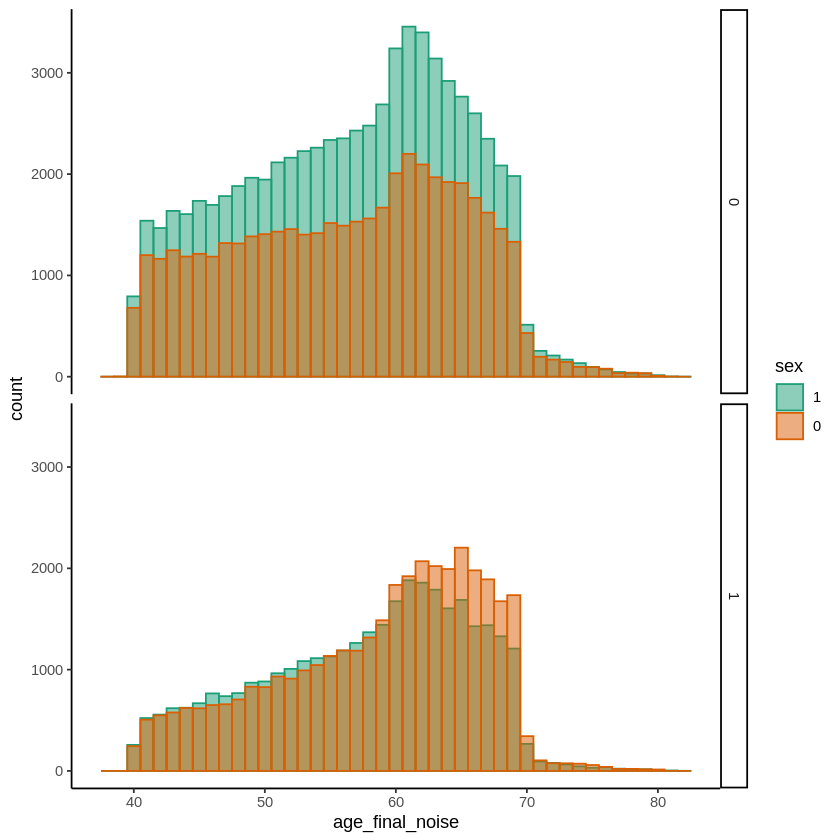

In [316]:
ggplot(f.2257_pheno, aes(x=age_final_noise, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(hearing_noise_cat ~ .)

## Find out controls positive for f.2247 & f.3393

In [317]:
control_check_2257 <- df_3393_2247_2257 %>%
    filter(hearing_noise_cat==0) %>%
    select(FID, IID, age_final_noise, sex, hearing_noise_cat, starts_with("f.2247"), starts_with("f.3393")) %>%
    mutate(remove_2247 = apply(select(.,starts_with("f.2247")), 1, function(x) length(which(x == "Yes")) > 0),
           remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_2257)

,FID,IID,age_final_noise,sex,hearing_noise_cat,f.2247.0.0,f.2247.1.0,f.2247.2.0,f.2247.3.0,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_2247,remove_3393
,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>,<lgl>
1,1000078,1000078,60,1,0,No,No,No,NA,NA,No,No,NA,NA,0,0,NA,FALSE,FALSE
2,1000081,1000081,67,0,0,No,NA,NA,NA,No,NA,NA,NA,0,NA,NA,NA,FALSE,FALSE
3,1000210,1000210,66,0,0,Do not know,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,FALSE
4,1000224,1000224,58,1,0,No,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,FALSE,FALSE
5,1000236,1000236,70,0,0,No,NA,No,NA,No,NA,No,NA,0,NA,0,NA,FALSE,FALSE
6,1000255,1000255,61,1,0,No,NA,No,NA,No,NA,No,NA,0,NA,0,NA,FALSE,FALSE


In [140]:
length(which(control_check_2257$remove_2247==TRUE)) #controls that replied yes to f.2247
length(which(control_check_2257$remove_3393==TRUE)) #controls that replied yes to f.3393
length(which(control_check_2257$remove_2247==TRUE & control_check_2257$remove_3393==TRUE)) # controls that replied yes to both
length(which(control_check_2257$remove_2247==TRUE | control_check_2257$remove_3393==TRUE)) # controls that replied yes to either

[1] 7385

[1] 271

[1] 222

[1] 7434

### Export files white-British

In [133]:
write.table(f.2257_pheno, '200828_UKBB_Hearing_background_noise_f2257', quote = FALSE, row.names = FALSE)

### Export files white expanded

In [133]:
write.table(f.2257_pheno, '120120_UKBB_Hearing_background_noise_f2257_expandedwhite', quote = FALSE, row.names = FALSE)

### Export files exome data

In [147]:
length(which(is.na(f.2257_pheno$sex)))

[1] 164

In [318]:
write.table(f.2257_pheno, 'phenotypes_exome_data/010421_UKBB_Hearing_background_noise_f2257_exomes', quote = FALSE, row.names = FALSE)

## Combined phenotype f.2247 and f.2257

In [319]:
hybrid_inconsistent <- df_3393_2247_2257 %>%
 filter(hearing_noise_cat != hearing_diff_new)
head(hybrid_inconsistent)
cat ("There are ",nrow(hybrid_inconsistent),"individuals inconsistent for f.2247 and f.2257")
dim(df_3393_2247_2257)

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,NA,0,63,0,63,control,control,0,1,63
2,1000304,1000304,0,0,2,-9,Female,1951,2008-02-15,NA,⋯,NA,0,56,0,56,control,control,0,1,56
3,1000817,1000817,0,0,1,-9,Male,1950,2009-04-18,NA,⋯,NA,0,58,0,58,control,control,0,1,58
4,1000988,1000988,0,0,2,-9,Female,1942,2008-04-10,NA,⋯,NA,0,65,0,65,control,control,0,1,65
5,1001080,1001080,0,0,2,-9,Female,1947,2010-04-30,NA,⋯,NA,0,62,0,62,control,control,0,1,62
6,1001316,1001316,0,0,1,-9,Male,1964,2010-04-08,NA,⋯,NA,0,51,1,51,case,control,1,0,51


There are  32814 individuals inconsistent for f.2247 and f.2257

[1] 193866   2276

In [320]:
length(which(!is.na(df_3393_2247_2257$hearing_noise_cat) & !is.na(df_3393_2247_2257$hearing_diff_new)))

[1] 177923

In [321]:
length(which(is.na(df_3393_2247_2257$hearing_noise_cat) | is.na(df_3393_2247_2257$hearing_diff_new))) 

[1] 15943

In [323]:
hybrid_consistent <- df_3393_2247_2257 %>%
 filter(hearing_noise_cat == hearing_diff_new)
head(hybrid_consistent)
cat ("There are ",nrow(hybrid_consistent),"individuals consistent for f.2247 and f.2257")

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,NA,0,47,1,47,case,control,1,1,47
2,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,NA,0,60,0,60,control,control,0,0,60
3,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,NA,0,67,0,67,control,control,0,0,67
4,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,NA,0,41,1,41,case,control,1,1,41
5,1000224,1000224,0,0,2,-9,Female,1951,2009-05-01,NA,⋯,NA,NA,NA,0,58,control,NA,0,0,58
6,1000236,1000236,0,0,1,-9,Male,1948,2010-01-30,NA,⋯,NA,0,70,0,70,control,control,0,0,70


There are  145109 individuals consistent for f.2247 and f.2257

In [324]:
age_consistency <- hybrid_consistent %>%
    select(IID, age_final_diff, age_final_noise)
head(age_consistency)

,IID,age_final_diff,age_final_noise
,<int>,<int>,<int>
1,1000019,47,47
2,1000078,60,60
3,1000081,67,67
4,1000198,41,41
5,1000224,58,58
6,1000236,70,70


In [325]:
# There are inconsistencies for the age between hearing difficulty and background noise
all(age_consistency$age_final_diff == age_consistency$age_final_noise)

[1] FALSE

In [326]:
age_inconsistency <- hybrid_consistent %>%
    filter(age_final_diff != age_final_noise)
head(age_inconsistency)
cat ("There are",nrow(age_inconsistency), "individuals with inconsistent ages for hearing difficulty and background noise")

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,f.3393.3.0_recode,hearing_aid_cat,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>
1,1006407,1006407,0,0,2,-9,Female,1949,2008-09-30,NA,⋯,NA,0,65,1,59,case,control,1,1,65
2,1006513,1006513,0,0,2,-9,Female,1955,2010-02-23,NA,⋯,NA,1,59,1,59,case,case,1,1,54
3,1012730,1012730,0,0,1,-9,Male,1947,2010-05-26,NA,⋯,0,0,73,1,70,case,control,1,1,63
4,1015865,1015865,0,0,2,-9,Female,1948,2010-04-27,NA,⋯,NA,0,71,1,71,case,control,1,1,62
5,1016086,1016086,0,0,1,-9,Male,1948,2008-08-20,NA,⋯,NA,0,70,1,60,case,control,1,1,70
6,1017495,1017495,0,0,1,-9,Male,1957,2008-08-04,NA,⋯,NA,0,58,1,58,case,control,1,1,51


There are 1946 individuals with inconsistent ages for hearing difficulty and background noise

In [327]:
age_inconsistency_cases <- hybrid_consistent %>%
    filter(hearing_noise_cat == 1 &  hearing_diff_new ==1) %>%
    filter(age_final_diff != age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise)
head(age_inconsistency_cases)
cat ("There are",nrow(age_inconsistency_cases), "cases with inconsistent ages for hearing difficulty and background noise")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>
1,1006407,1006407,1,1,1,59,65
2,1006513,1006513,1,1,1,59,54
3,1012730,1012730,0,1,1,70,63
4,1015865,1015865,1,1,1,71,62
5,1016086,1016086,0,1,1,60,70
6,1017495,1017495,0,1,1,58,51


There are 1944 cases with inconsistent ages for hearing difficulty and background noise

In [328]:
age_inconsistency_controls <- hybrid_consistent %>%
    filter(hearing_noise_cat == 0 &  hearing_diff_new == 0) %>%
    filter(age_final_diff != age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise)
head(age_inconsistency_controls)
cat ("There are",nrow(age_inconsistency_controls), "controls with inconsistent ages for hearing difficulty and background noise")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>
1,1740024,1740024,0,0,0,41,46
2,5668953,5668953,1,0,0,74,69


There are 2 controls with inconsistent ages for hearing difficulty and background noise

In [329]:
#get the minimum age for 2247 and 2257 for cases
age_inconsistency_cases <- transform(age_inconsistency_cases, age_diff_noise = pmin(age_final_noise, age_final_diff))
head(age_inconsistency_cases)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1006407,1006407,1,1,1,59,65,59
2,1006513,1006513,1,1,1,59,54,54
3,1012730,1012730,0,1,1,70,63,63
4,1015865,1015865,1,1,1,71,62,62
5,1016086,1016086,0,1,1,60,70,60
6,1017495,1017495,0,1,1,58,51,51


In [330]:
#get the maximun age for 2247 and 2257 for controls
age_inconsistency_controls <- transform(age_inconsistency_controls, age_diff_noise = pmax(age_final_noise, age_final_diff))
head(age_inconsistency_controls,10)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1740024,1740024,0,0,0,41,46,46
2,5668953,5668953,1,0,0,74,69,74


In [331]:
age_solved <- rbind(age_inconsistency_cases, age_inconsistency_controls)
nrow(age_solved)
head(age_solved)

[1] 1946

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1006407,1006407,1,1,1,59,65,59
2,1006513,1006513,1,1,1,59,54,54
3,1012730,1012730,0,1,1,70,63,63
4,1015865,1015865,1,1,1,71,62,62
5,1016086,1016086,0,1,1,60,70,60
6,1017495,1017495,0,1,1,58,51,51


In [332]:
hybrid_age_consistent <- hybrid_consistent  %>%
    filter(age_final_diff == age_final_noise) %>%
    select(FID, IID, sex, hearing_diff_new, hearing_noise_cat, age_final_diff, age_final_noise) %>%
    mutate(age_diff_noise = age_final_diff) 
head(hybrid_age_consistent)
cat ("There are ",nrow(hybrid_age_consistent),"individuals consistent for age and phenotype for f.2247 and f.2257")

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,1,1,1,47,47,47
2,1000078,1000078,1,0,0,60,60,60
3,1000081,1000081,0,0,0,67,67,67
4,1000198,1000198,1,1,1,41,41,41
5,1000224,1000224,1,0,0,58,58,58
6,1000236,1000236,0,0,0,70,70,70


There are  143163 individuals consistent for age and phenotype for f.2247 and f.2257

In [333]:
f2247_f2257_pheno <- rbind (hybrid_age_consistent, age_solved)
head(f2247_f2257_pheno)
nrow(f2247_f2257_pheno)

,FID,IID,sex,hearing_diff_new,hearing_noise_cat,age_final_diff,age_final_noise,age_diff_noise
,<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000019,1000019,1,1,1,47,47,47
2,1000078,1000078,1,0,0,60,60,60
3,1000081,1000081,0,0,0,67,67,67
4,1000198,1000198,1,1,1,41,41,41
5,1000224,1000224,1,0,0,58,58,58
6,1000236,1000236,0,0,0,70,70,70


[1] 145109

In [334]:
names(f2247_f2257_pheno)[names(f2247_f2257_pheno) == 'hearing_diff_new'] <- 'f2247_f2257'
names(f2247_f2257_pheno)[names(f2247_f2257_pheno) == 'age_diff_noise'] <- 'age_combined'
f2247_f2257_pheno <- f2247_f2257_pheno %>%
 select(FID, IID, age_combined, sex, f2247_f2257 )
head(f2247_f2257_pheno)

,FID,IID,age_combined,sex,f2247_f2257
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,1,1
2,1000078,1000078,60,1,0
3,1000081,1000081,67,0,0
4,1000198,1000198,41,1,1
5,1000224,1000224,58,1,0
6,1000236,1000236,70,0,0


In [335]:
cases_combined <- f2247_f2257_pheno %>%
    filter(f2247_f2257 == 1)
nrow(cases_combined)

[1] 40488

In [336]:
controls_combined <- f2247_f2257_pheno %>%
    filter(f2247_f2257 == 0)
nrow(controls_combined)

[1] 104621

## Merge with complete database

In [337]:
#Merge with complete database keep the all the rows from original db
df_3393_2247_2257_combined = merge(x = df_3393_2247_2257, y = f2247_f2257_pheno [,c("IID","f2247_f2257","age_combined")],by="IID", all.x=TRUE)
dim(df_3393_2247_2257_combined)
head(df_3393_2247_2257_combined)

[1] 193866   2278

,IID,FID,ignore1,ignore2,ignore3,ignore4,f.31.0.0,f.34.0.0,f.53.0.0,f.53.1.0,⋯,age_final_aid,hearing_diff_cat,age_final_diff,hearing_diff_cat_new,hearing_aid_cat_new,hearing_diff_new,hearing_noise_cat,age_final_noise,f2247_f2257,age_combined
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<int>,<fct>,<fct>,⋯,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>
1,1000019,1000019,0,0,2,-9,Female,1960,2008-01-24,NA,⋯,47,1,47,case,control,1,1,47,1,47
2,1000035,1000035,0,0,1,-9,Male,1944,2007-11-08,NA,⋯,63,0,63,control,control,0,1,63,NA,NA
3,1000078,1000078,0,0,2,-9,Female,1955,2007-08-20,2012-11-01,⋯,60,0,60,control,control,0,0,60,0,60
4,1000081,1000081,0,0,1,-9,Male,1942,2009-12-03,NA,⋯,67,0,67,control,control,0,0,67,0,67
5,1000198,1000198,0,0,2,-9,Female,1967,2009-03-27,NA,⋯,41,1,41,case,control,1,1,41,1,41
6,1000210,1000210,0,0,1,-9,Male,1941,2008-02-11,NA,⋯,NA,NA,NA,NA,NA,NA,0,66,NA,NA


## Histogram for age of cases and controls

In [338]:
f2247_f2257_pheno <- f2247_f2257_pheno %>%
 select(FID, IID, age_combined, sex, f2247_f2257 )
 #mutate(f2247_f2257=recode_factor(f2247_f2257, `1`="case",`0`="control"),sex=recode_factor(sex, `1`="male", `0`="female" ))
head(f2247_f2257_pheno)
dim(f2247_f2257_pheno)

,FID,IID,age_combined,sex,f2247_f2257
,<int>,<int>,<int>,<fct>,<fct>
1,1000019,1000019,47,1,1
2,1000078,1000078,60,1,0
3,1000081,1000081,67,0,0
4,1000198,1000198,41,1,1
5,1000224,1000224,58,1,0
6,1000236,1000236,70,0,0


[1] 145109      5

In [339]:
mu7 <- ddply(f2247_f2257_pheno, "f2247_f2257", summarise, grp.mean=mean(age_combined))
head(mu7)

,f2247_f2257,grp.mean
,<fct>,<dbl>
1,0,56.34014
2,1,59.19213


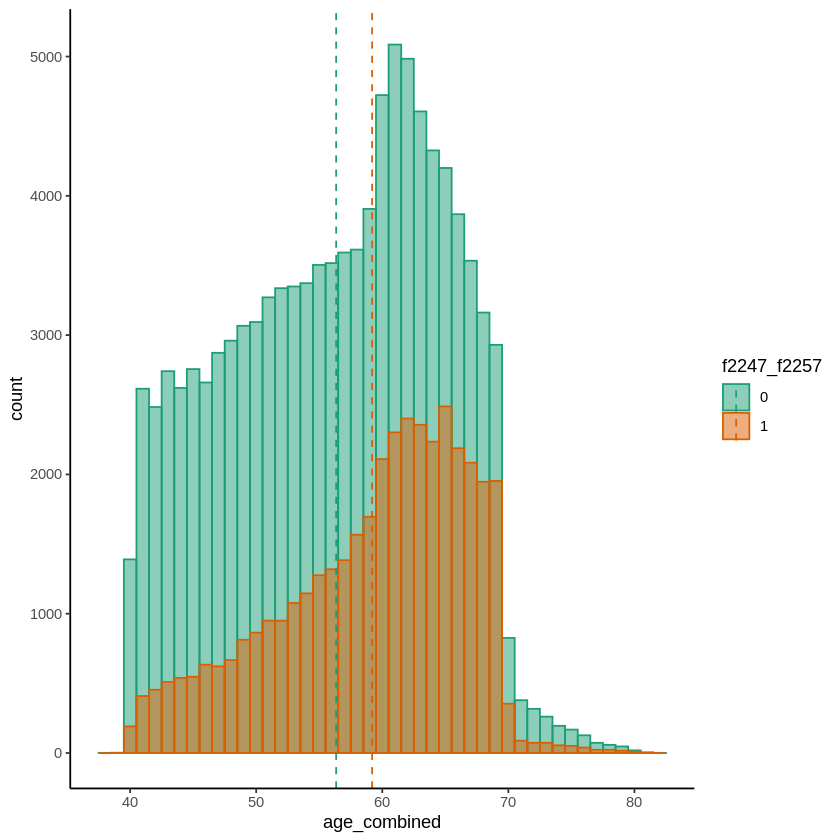

In [340]:
ggplot(f2247_f2257_pheno, aes(x=age_combined, fill=f2247_f2257, color=f2247_f2257)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  geom_vline(data=mu7, aes(xintercept=grp.mean, color=f2247_f2257),
             linetype="dashed") +
  theme_classic()

In [341]:
length(which((f2247_f2257_pheno$f2247_f2257=="0" & f2247_f2257_pheno$age_combined <50)))

[1] 26170

In [342]:
length(which((f2247_f2257_pheno$f2247_f2257=="1" & f2247_f2257_pheno$age_combined <50)))

[1] 5386

In [343]:
mu8 <- ddply(f2247_f2257_pheno, "sex", summarise, grp.mean=mean(age_combined))
head(mu8)

,sex,grp.mean
,<fct>,<dbl>
1,1,56.95069
2,0,57.37212


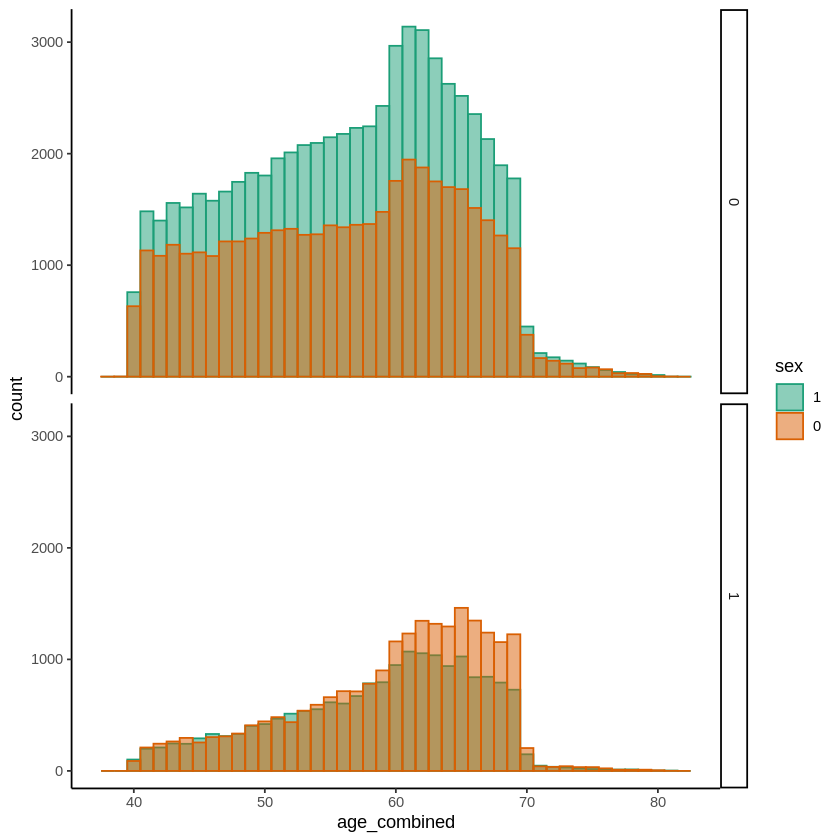

In [344]:
ggplot(f2247_f2257_pheno, aes(x=age_combined, fill=sex, color=sex)) +
 geom_histogram(binwidth=1, alpha=0.5, position="identity")+
  scale_color_brewer(palette="Dark2")+
  scale_fill_brewer(palette="Dark2") +
  theme(legend.position="top") +
  theme_classic() +
  facet_grid(f2247_f2257 ~ .)

In [345]:
#Summary age of cases and controls
tapply(f2247_f2257_pheno$age_combined,  f2247_f2257_pheno$f2247_f2257, summary)

$`0`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  38.00   49.00   57.00   56.34   63.00   82.00 

$`1`
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   54.00   61.00   59.19   65.00   81.00 


## Find out controls positive for  f.3393

In [346]:
control_check_combined <- df_3393_2247_2257_combined %>%
    filter(f2247_f2257==0) %>%
    select(FID, IID, age_combined, sex, f2247_f2257, starts_with("f.3393")) %>%
    mutate(remove_3393 = apply(select(.,starts_with("f.3393")), 1, function(x) length(which(x == "Yes")) > 0))
head(control_check_combined)
dim(control_check_combined)

,FID,IID,age_combined,sex,f2247_f2257,f.3393.0.0,f.3393.1.0,f.3393.2.0,f.3393.3.0,f.3393.0.0_recode,f.3393.1.0_recode,f.3393.2.0_recode,f.3393.3.0_recode,remove_3393
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>
1,1000078,1000078,60,1,0,NA,No,No,NA,NA,0,0,NA,FALSE
2,1000081,1000081,67,0,0,No,NA,NA,NA,0,NA,NA,NA,FALSE
3,1000224,1000224,58,1,0,NA,NA,NA,NA,NA,NA,NA,NA,FALSE
4,1000236,1000236,70,0,0,No,NA,No,NA,0,NA,0,NA,FALSE
5,1000255,1000255,61,1,0,No,NA,No,NA,0,NA,0,NA,FALSE
6,1000272,1000272,43,0,0,No,NA,NA,NA,0,NA,NA,NA,FALSE


[1] 104621     14

In [347]:
length(which(control_check_combined$remove_3393==TRUE)) #controls that replied yes to f.3393

[1] 3

### Export file white-British

In [162]:
write.table(f2247_f2257_pheno, '200828_UKBB_f2247_f2257', quote = FALSE, row.names = FALSE)

### Export file white expanded

In [162]:
write.table(f2247_f2257_pheno, '120120_UKBB_f2247_f2257_expandedwhite', quote = FALSE, row.names = FALSE)

### Export exome data

In [348]:
write.table(f2247_f2257_pheno, 'phenotypes_exome_data/010421_UKBB_f2247_f2257_exomes', quote = FALSE, row.names = FALSE)